## Тут просто ручная реализация логистической регрессии с сигмоидой и регуляризацией на датасете Titanic

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import sys
module_path = os.path.abspath('..')
if module_path not in sys.path:
    sys.path.append(module_path)

In [8]:
def prepare_dataset(df):
    df = df.drop(['Name', 'Ticket', 'Cabin', 'Embarked'], axis=1)
    df['Sex'] = (train_data['Sex'] == 'male').astype(np.int) * 2 - 1
    df = df.fillna({'Age': df['Age'].mean()})
    df['Age'] /= 100
    df['Fare'] /= 100
    df['_bias'] = 1
    if 'Survived' in df.columns:
        return df.drop(['Survived'], axis=1), (df['Survived'] * 2 - 1)
    else:
        return df

In [9]:
train_data = pd.read_csv('../data/titanic/train.csv')
train_features, train_answers = prepare_dataset(train_data)

In [10]:
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', '_bias']
X = train_features[features].to_numpy()
y = train_answers.to_numpy()

common_test_X, common_test_y = X[:X.shape[0] // 10], y[:X.shape[0] // 10]
X, y = X[X.shape[0] // 10:], y[X.shape[0] // 10:]

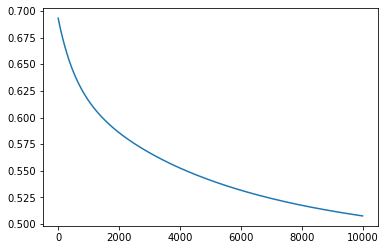

In [11]:
from tqdm.notebook import tqdm
iterations = 10000
alpha = 5e-4
tau = 1e-4

def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

w = np.zeros((X.shape[1]))
errors = []
best_w = w
best_err = None
for it in tqdm(range(iterations)):
    errors.append(tau / 2 * np.sum(w**2) +
                  -np.mean(np.log( sigmoid(y * (X @ w)) ) )
                 )
    if best_err is None or errors[-1] < best_err:
        best_w = w
        best_err = errors[-1]
    w -= alpha * (-np.array([
        np.dot(y * sigmoid(- y * (X @ w)), X[:, j])
        for j in range(X.shape[1])
    ]) / X.shape[0] + tau * w)
    if it % 2000 == 0: alpha *= 0.99

plt.plot([i for i in range(len(errors))], errors)

In [12]:
print(best_err)
pd.DataFrame({'feature': features, 'weight': best_w})

0.5076849397899177


,feature,weight
0,Pclass,-0.275670
1,Sex,-0.704477
2,Age,-0.004344
3,SibSp,-0.044998
4,Parch,0.069894
5,Fare,0.220043
6,_bias,0.077582


In [13]:
train_predictions = (sigmoid(common_test_X @ w) >= 0.5).astype(np.int) * 2 - 1
print('Score: {}'.format( np.mean( train_predictions == common_test_y ) ))

Score: 0.7528089887640449


In [14]:
topology_pair = [(0, 1)]
topology_cycle_3 = [(0, 1), (1, 2), (2, 0)] 
topology_grid_5 = [('center', 'west'), ('center', 'east'), ('center', 'north'), ('center', 'south'),
                   ('west', 'north'), ('north', 'east'), ('east', 'south'), ('west', 'south')]
'''
     @
    /|\
   @-@-@  topology_grid_5
    \|/
     @
'''
from utils.consensus_asyncio import *

Посчитаем среднее пяти случайных чисел

In [15]:
consensus_shutdown = asyncio.Queue()
consensus_network = ConsensusNetwork(topology_grid_5, consensus_shutdown, debug=True)
agents = [ConsensusAgent(token, debug=True) for token in consensus_network.tokens]
for a in agents:
    consensus_network.register_agent(a)

async def shutdown_after_timeout(consensus_shutdown, timeout):
    await asyncio.sleep(timeout)
    await consensus_shutdown.put(SHUTDOWN)

tasks = [asyncio.create_task(a.run_round(n + 1, 1 / (n + 1))) for n, a in enumerate(agents)]
asyncio.create_task(consensus_network.serve())
asyncio.create_task(shutdown_after_timeout(consensus_shutdown, 1))
for coro in asyncio.as_completed(tasks):
    t = await coro
    print(t)

2.1897810218978107
2.1897810218978107
2.18978102189781
2.1897810218978107
2.1897810218978107


Master: Got 1/5 agents
Master: Got 2/5 agents
Master: Got 3/5 agents
Master: Got 4/5 agents
Master: Got 5/5 agents
Agent "west": heard from master
Agent "north": heard from master
Agent "center": heard from master
Agent "east": heard from master
Agent "south": heard from master
Agent "west": got neighbors from master
Agent "west": got consensus epsilon from master: 0.2375
Agent "north": got neighbors from master
Agent "north": got consensus epsilon from master: 0.2375
Agent "center": got neighbors from master
Agent "center": got consensus epsilon from master: 0.2375
Agent "east": got neighbors from master
Agent "east": got consensus epsilon from master: 0.2375
Agent "south": got neighbors from master
Agent "south": got consensus epsilon from master: 0.2375
Agent "west": running new round with v=1, w=1.0
Agent "west": initialized. Waiting for NETWORK_READY
Agent "west": got NETWORK_READY
Agent "west": clearing queues
Agent "west": sending NEW_ROUND to master
Agent "north": running new r

## Применение для титаника

In [16]:
def split_data(X, y, topology):
    tmpX = X.copy()
    tmpy = y.copy()
    tokens = list(set(np.array(topology).flatten()))
    num = len(tokens)
    result = dict()
    for i in range(num):
        left_tokens = num - i
        left_data = len(tmpX)
        ln = left_data // left_tokens
        result[tokens[i]] = (tmpX[:ln], tmpy[:ln])
        tmpX, tmpy = tmpX[ln:], tmpy[ln:]
    return result

In [17]:
from utils.consensus_asyncio import *
consensus_network = ConsensusNetwork(topology_grid_5, None)
consensus_network.describe()

Laplacian:
[[ 3 -1 -1  0 -1]
 [-1  3 -1 -1  0]
 [-1 -1  4 -1 -1]
 [ 0 -1 -1  3 -1]
 [-1  0 -1 -1  3]]
Eigenvalues: [0. 3. 3. 5. 5.]
Algebraic connectivity: 2.999999999999998
Perron matrix:
[[0.2875 0.2375 0.2375 0.     0.2375]
 [0.2375 0.2875 0.2375 0.2375 0.    ]
 [0.2375 0.2375 0.05   0.2375 0.2375]
 [0.     0.2375 0.2375 0.2875 0.2375]
 [0.2375 0.     0.2375 0.2375 0.2875]]
Eigenvalues: [-0.1875 -0.1875  0.2875  0.2875  1.    ]
Convergence speed: 0.18749999999999978


Вычисление 10000 итераций может занять минут 10, т.к. пока всё в один поток.

FloatProgress(value=0.0, max=1.0)

Score: 0.8089887640449438
Score: 0.8089887640449438
Score: 0.8089887640449438
Score: 0.8089887640449438
Score: 0.8089887640449438
W: [-0.83225111 -2.85822261  0.0502653  -0.15454473  0.33420918  1.04908348
  0.55818859]
W: [-0.83224841 -2.85821341  0.05026513 -0.15454422  0.33420813  1.04908009
  0.55818679]
W: [-0.83224978 -2.85821805  0.05026521 -0.15454449  0.33420867  1.04908179
  0.5581877 ]
W: [-0.83225136 -2.85822346  0.05026531 -0.1545448   0.3342093   1.04908378
  0.55818875]
W: [-0.83225088 -2.85822183  0.05026528 -0.15454469  0.3342091   1.04908319
  0.55818844]


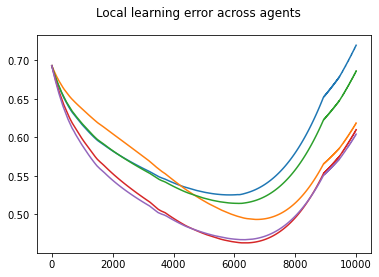

In [18]:
def sigmoid(x):
        return 1.0 / (1.0 + np.exp(-x))

progress_info = {}

async def learning_instance(X, y, agent, iterations=50000):
    alpha = 5e-4
    tau = 1e-4

    w = np.zeros((X.shape[1]))
    errors = []
    for it in range(iterations):
        errors.append(tau / 2 * np.sum(w**2) +
                      -np.mean(np.log( sigmoid(y * (X @ w)) ) )
                     )
        grad = -np.array([
            np.dot(y * sigmoid(- y * (X @ w)), X[:, j])
            for j in range(X.shape[1])
        ]) / X.shape[0] + tau * w
        w -= alpha * grad
        w = await agent.run_round(w, X.shape[0])
        if it % 2000 == 0: alpha *= 0.99
        progress_info[agent.token] = (it + 1) / iterations

    return w, errors[-1], errors

async def run(topology, iterations=100, timeout=None, debug=False):
    dl_data = split_data(X, y, topology)
    consensus_shutdown = asyncio.Queue()
    consensus_network = ConsensusNetwork(topology, consensus_shutdown, debug=debug)
    agents = [ConsensusAgent(token, convergence_eps=1e-5, debug=debug) for token in consensus_network.tokens]
    for a in agents:
        consensus_network.register_agent(a)

    async def print_progress():
        from ipywidgets import IntProgress, FloatProgress, FloatText
        from IPython.display import display

        progress = FloatProgress(min=0.0, max=1.0, step=0.01, value=0.0)
        display(progress)
        while True:
            v = list(progress_info.values())
            if len(v) > 0:
                p = np.mean(v)
                progress.value = p
            await asyncio.sleep(0.25)

    if timeout:
        asyncio.create_task(shutdown_after_timeout(consensus_shutdown, timeout))
    progress_task = asyncio.create_task(print_progress())
    tasks = [asyncio.create_task(
                learning_instance(dl_data[a.token][0], dl_data[a.token][1], a, iterations=iterations)
             ) for a in agents]
    asyncio.create_task(consensus_network.serve())
    best_ws = []
    for coro in asyncio.as_completed(tasks):
        best_w, best_err, errors = await coro
        best_ws.append(best_w)
        plt.plot([i for i in range(len(errors))], errors)
    plt.suptitle('Local learning error across agents')
    progress_task.cancel()

    for w in best_ws:
        train_predictions = (sigmoid(common_test_X @ w) >= 0.5).astype(np.int) * 2 - 1
        print(f'Score: {np.mean( train_predictions == common_test_y )}')

    for w in best_ws:
        print(f'W: {w}')

await run(topology_grid_5, 10000)